In [33]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from svetlanna.phase_retrieval_problem import phase_retrieval
from svetlanna import SimulationParameters
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna import LinearOpticalSetup

We solve the problem of direct propagation of a Gaussian beam through the system with SLM and thin lens. Problem: optimize SLM's mask for generating the square in the back focal plane of the thin lens.

In [34]:
# optical setup sizem mm
lx = 20
ly = 20

# number of nodes
Nx = 1000
Ny = 1000
# wavelength
lam = 1064 * 1e-6

# focal distance of the lens
focal = 100
# radius of the lens
r = 10
# distance between the screen od the lens
distance = focal

# waist radius of the gaussian beam, mm
w0 = 2

x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = np.meshgrid(x, y)


dx = lx / Nx
dy = ly / Ny

params = SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)


In [35]:
field_before_slm = Wavefront.gaussian_beam(simulation_parameters=params, distance=distance, waist_radius=w0)

intensity_source = field_before_slm.intensity.detach().numpy()

free_space1 = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal), method='AS')

lens = elements.ThinLens(simulation_parameters=params, focal_length=focal, radius=r)

free_space2 = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal), method='AS')

optical_setup = LinearOpticalSetup([free_space1, lens, free_space2])

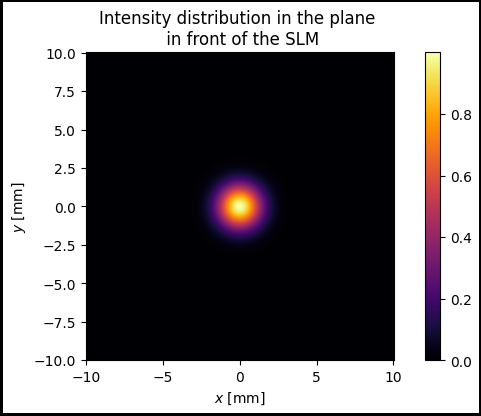

In [36]:
fig, ax = plt.subplots(figsize=(8, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_source, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity distribution in the plane \n in front of the SLM')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [37]:
intensity_target = ((np.abs(xv)<=lx/10) * (np.abs(yv)<=ly/12)).astype(float)
energy = torch.sum(field_before_slm.intensity)

N = int(np.sum(intensity_target))

intensity_target = intensity_target * float(energy) / N

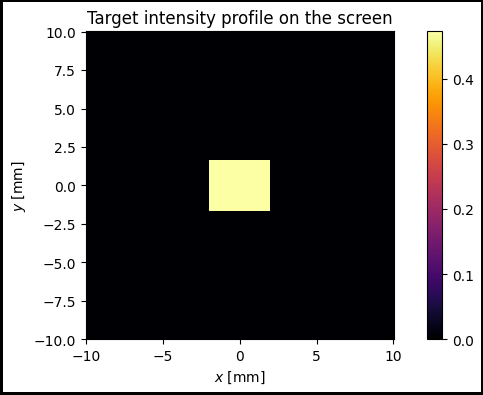

In [48]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Target intensity profile on the screen')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [49]:
result_hio = phase_retrieval.retrieve_phase(
    source_intensity=torch.tensor(intensity_source),
    optical_setup=optical_setup,
    target_intensity=torch.tensor(intensity_target),
    method='HIO',
    initial_phase=None
)

phase_distribution_hio = result_hio.solution
niter_hio = result_hio.number_of_iterations
error_mass_hio = result_hio.cost_func_evolution


step = 2 * torch.pi / 256
mask = phase_distribution_hio // step

In [50]:
n_hio = np.arange(1, niter_hio+1)

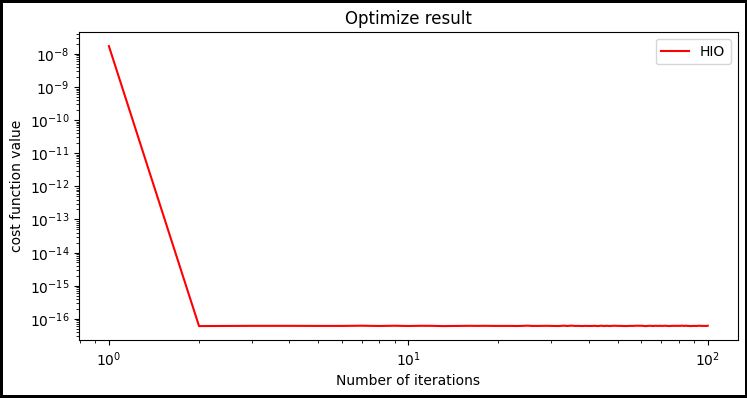

In [51]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)

ax.set_title(r'Optimize result')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('cost function value')

ax.loglog(n_hio, error_mass_hio, label='HIO', color='red')

ax.legend()

Let's solve the problem of direct propagation of the Gaussian beam thought the system again with optimized mask:

In [52]:
field_after_slm = elements.SpatialLightModulator(simulation_parameters=params, mask=mask).forward(field_before_slm)
output_field = optical_setup.forward(field_after_slm)
intensity_target_opt = torch.pow(torch.abs(output_field), 2).detach().numpy()

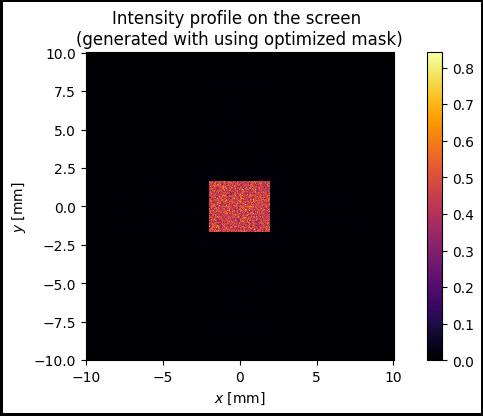

In [58]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Intensity profile on the screen \n(generated with using optimized mask)')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

Highlight the region of interest:

In [ ]:
region = (intensity_target != 0).astype(int)

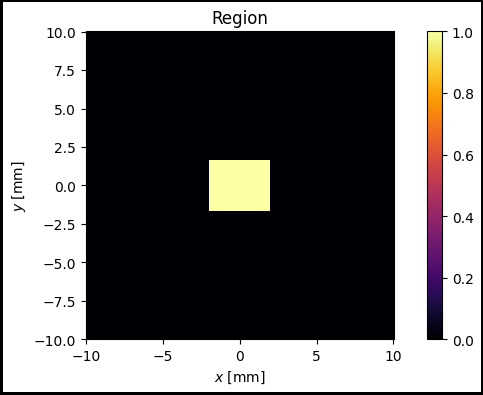

In [55]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, region, cmap='inferno')
ax.set_aspect('equal')
ax.set_title('Region')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [56]:
goalx = region[int(Ny/2), :]

goaly = region[:, int(Nx/2)]

indicesx = np.where(goalx == 1.)
indicesy = np.where(goaly == 1.)

Nx_min = indicesx[0][0]
Nx_max = indicesx[0][-1]

Ny_min = indicesy[0][0]
Ny_max = indicesy[0][-1]


# total number of pixels in region
N_total = len(indicesx[0]) * len(indicesy[0])

In [57]:
intensity_target_opt_region = intensity_target_opt[Ny_min:Ny_max, Nx_min:Nx_max]

efficiency = np.sum(intensity_target_opt_region)


average_intensity = efficiency / N_total

maxi = np.max(intensity_target_opt_region)
mini = np.min(intensity_target_opt_region)

uniformity = 1 - (maxi - mini) / (maxi + mini)

standard_error = 100 * np.sum((intensity_target_opt_region - average_intensity)**2)/ (N_total * average_intensity)

eff = np.sum(intensity_target_opt_region) / np.sum(intensity_target_opt) * 100

print('Efficiency:' + str(efficiency))
print('Average intensity:'  + str(average_intensity))
print('Uniformity:' + str(uniformity))
print('Standard error:' + str(standard_error) + '%')

print('Power relation:' + str(eff) + '%')



Efficiency:15036.565019677035
Average intensity:0.45290858493003117
Uniformity:0.38485975208169776
Standard error:1.3722954068450508%
Power relation:95.91752833673782%
